# VTK File Visualization with Interactive Widgets

This notebook provides an interactive interface for visualizing and analyzing VTK files from the aneurysm simulation.

In [2]:
# Import required libraries
import os
import sys
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib.colors import LinearSegmentedColormap

## Helper Functions for VTK Files

First, let's define functions to load and extract data from VTK files.

In [3]:
def natural_sort_key(s):
    """Sort strings with embedded numbers naturally"""
    return [int(c) if c.isdigit() else c.lower() for c in re.split(r'(\d+)', s)]

def find_vtk_files(base_dir=None):
    """Find VTK files in the specified or default directories"""
    # Try default locations
    if base_dir is None:
        possible_dirs = [
            os.path.join(os.getcwd(), "aneurysm_simulation_results", "vtk"),
            os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "aneurysm_simulation_results", "vtk")),
            "/home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results/vtk"
        ]
        
        for path in possible_dirs:
            if os.path.exists(path) and os.path.isdir(path):
                vtk_files = glob.glob(os.path.join(path, "*.vtk"))
                if vtk_files:
                    print(f"Found {len(vtk_files)} VTK files in {path}")
                    return sorted(vtk_files, key=natural_sort_key), path
        
        print("No VTK files found in default directories.")
        return [], None
    else:
        if os.path.exists(base_dir) and os.path.isdir(base_dir):
            vtk_files = glob.glob(os.path.join(base_dir, "*.vtk"))
            if vtk_files:
                print(f"Found {len(vtk_files)} VTK files in {base_dir}")
                return sorted(vtk_files, key=natural_sort_key), base_dir
        
        print(f"No VTK files found in {base_dir}")
        return [], None

def read_vtk_file(vtk_file_path):
    """Read a VTK file and return data fields as NumPy arrays"""
    # First, try to determine the VTK file type
    try:
        with open(vtk_file_path, 'r') as f:
            for line in f:
                if 'DATASET' in line:
                    dataset_type = line.split()[1].strip()
                    print(f"Detected dataset type: {dataset_type}")
                    break
    except Exception as e:
        print(f"Error reading file header: {e}")
        dataset_type = None
    
    # Set up appropriate reader based on dataset type
    reader = None
    if dataset_type == 'STRUCTURED_POINTS':
        reader = vtk.vtkStructuredPointsReader()
    elif dataset_type == 'UNSTRUCTURED_GRID':
        reader = vtk.vtkUnstructuredGridReader()
    elif dataset_type == 'POLYDATA':
        reader = vtk.vtkPolyDataReader()
    elif dataset_type == 'STRUCTURED_GRID':
        reader = vtk.vtkStructuredGridReader()
    elif dataset_type == 'RECTILINEAR_GRID':
        reader = vtk.vtkRectilinearGridReader()
    
    # If we couldn't determine the type, try multiple readers
    if reader is None:
        readers = [
            vtk.vtkStructuredPointsReader(),
            vtk.vtkUnstructuredGridReader(),
            vtk.vtkPolyDataReader(),
            vtk.vtkStructuredGridReader(),
            vtk.vtkRectilinearGridReader()
        ]
    else:
        readers = [reader]
    
    # Try reading with appropriate readers
    for reader in readers:
        try:
            reader.SetFileName(vtk_file_path)
            reader.Update()
            data = reader.GetOutput()
            
            # Check for point data
            point_data = data.GetPointData()
            if point_data and point_data.GetNumberOfArrays() > 0:
                break
                
            # If no point data, try cell data
            cell_data = data.GetCellData()
            if cell_data and cell_data.GetNumberOfArrays() > 0:
                print(f"Found {cell_data.GetNumberOfArrays()} arrays in cell data")
                break
                
        except Exception as e:
            print(f"Error with reader {reader.GetClassName()}: {e}")
            continue
    else:
        # No valid reader found
        print(f"Error: Could not read {vtk_file_path} with any VTK reader")
        return None, None, []
    
    # Extract dimensions
    dimensions = data.GetDimensions() if hasattr(data, 'GetDimensions') else None
    
    # Check both point data and cell data
    fields = {}
    field_names = []
    
    # First try point data
    point_data = data.GetPointData()
    if point_data and point_data.GetNumberOfArrays() > 0:
        print(f"Processing {point_data.GetNumberOfArrays()} point data arrays")
        # Process point data
        for i in range(point_data.GetNumberOfArrays()):
            field_name = point_data.GetArrayName(i)
            vtk_array = point_data.GetArray(field_name)
            numpy_array = vtk_to_numpy(vtk_array)
            
            # Try to reshape the array if dimensions are available
            if dimensions and len(dimensions) >= 2:
                try:
                    # Assume 2D data (height, width)
                    reshaped_array = numpy_array.reshape(dimensions[1], dimensions[0])
                    fields[field_name] = reshaped_array
                except ValueError as e:
                    print(f"Reshape error for {field_name}: {e}")
                    # If reshaping fails, use the flat array
                    fields[field_name] = numpy_array
            else:
                fields[field_name] = numpy_array
                
            field_names.append(field_name)
    
    # If no point data fields were found, try cell data
    if not field_names:
        cell_data = data.GetCellData()
        if cell_data and cell_data.GetNumberOfArrays() > 0:
            print(f"Processing {cell_data.GetNumberOfArrays()} cell data arrays")
            # Process cell data
            for i in range(cell_data.GetNumberOfArrays()):
                field_name = cell_data.GetArrayName(i)
                vtk_array = cell_data.GetArray(field_name)
                numpy_array = vtk_to_numpy(vtk_array)
                
                # For cell data in structured points, the dimensions need to be adjusted
                if dimensions and len(dimensions) >= 2:
                    try:
                        # For cell data in a structured grid, dimensions are typically (nx-1) × (ny-1)
                        cell_dims = (dimensions[1]-1, dimensions[0]-1)
                        if numpy_array.size == cell_dims[0] * cell_dims[1]:
                            reshaped_array = numpy_array.reshape(cell_dims)
                            fields[field_name] = reshaped_array
                        else:
                            print(f"Cannot reshape cell data for {field_name}: size mismatch")
                            fields[field_name] = numpy_array
                    except ValueError as e:
                        print(f"Reshape error for cell data {field_name}: {e}")
                        fields[field_name] = numpy_array
                else:
                    fields[field_name] = numpy_array
                    
                field_names.append(field_name)
    
    if not field_names:
        print(f"Warning: No fields found in {vtk_file_path}")
    else:
        print(f"Found fields: {', '.join(field_names)}")
        
    return fields, dimensions, field_names

## Load VTK Files

Now let's load the VTK files from the default directory or a user-specified path.

In [4]:
# Find VTK files
vtk_files, vtk_dir = find_vtk_files()

# Optional: Specify a different directory
# vtk_files, vtk_dir = find_vtk_files('/path/to/vtk/files')

if not vtk_files:
    print("No VTK files found. Please check the path or provide a different directory.")
else:
    print(f"Found {len(vtk_files)} VTK files in {vtk_dir}")

Found 101 VTK files in /home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results/vtk
Found 101 VTK files in /home/abdua786/code/uni/3/dissertation/dissertation/aneurysm_simulation_results/vtk


## Extract Field Information

Let's extract the available fields from the first VTK file to set up our visualization.

In [5]:
if vtk_files:
    # Load the first file to get fields
    first_file = vtk_files[0]
    print(f"Analyzing first file: {os.path.basename(first_file)}")
    
    # Read the file
    fields, dimensions, field_names = read_vtk_file(first_file)
    
    if fields:
        print(f"\nAvailable fields:")
        for field in field_names:
            field_data = fields[field]
            print(f"  - {field}: shape={field_data.shape}, range=[{np.min(field_data):.4f}, {np.max(field_data):.4f}]")
        
        # Set default field for visualization
        default_field = "u_magnitude" if "u_magnitude" in field_names else field_names[0]
    else:
        print("No valid fields found in the first VTK file.")

Analyzing first file: aneurysm_0100000.vtk
Error reading file header: 'utf-8' codec can't decode byte 0xe8 in position 178: invalid continuation byte
Found 5 arrays in cell data
Processing 5 cell data arrays
Found fields: rho, u_x, u_y, u_magnitude, wss

Available fields:
  - rho: shape=(528, 749), range=[0.6444, 1.0000]
  - u_x: shape=(528, 749), range=[-0.1610, 0.1099]
  - u_y: shape=(528, 749), range=[-0.0506, 0.1324]
  - u_magnitude: shape=(528, 749), range=[0.0000, 0.1610]
  - wss: shape=(528, 749), range=[0.0000, 7.0056]


## Create Interactive Visualization

Now let's create interactive widgets to visualize and analyze the VTK files.

In [6]:
if vtk_files and fields:
    # Create colormap options
    colormap_options = ['viridis', 'plasma', 'inferno', 'magma', 'jet', 'hot', 'cool', 'rainbow']
    
    # Create widgets
    frame_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(vtk_files) - 1,
        step=1,
        description='Frame:',
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )
    
    field_dropdown = widgets.Dropdown(
        options=field_names,
        value=default_field,
        description='Field:',
        disabled=False,
    )
    
    colormap_dropdown = widgets.Dropdown(
        options=colormap_options,
        value='viridis',
        description='Colormap:',
        disabled=False,
    )
    
    auto_range_checkbox = widgets.Checkbox(
        value=True,
        description='Auto Range',
        disabled=False
    )
    
    vmin_slider = widgets.FloatSlider(
        value=0.0,
        min=-10.0,
        max=10.0,
        step=0.1,
        description='Min:',
        disabled=True,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.2f',
    )
    
    vmax_slider = widgets.FloatSlider(
        value=1.0,
        min=-10.0,
        max=10.0,
        step=0.1,
        description='Max:',
        disabled=True,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.2f',
    )
    
    play_button = widgets.Play(
        value=0,
        min=0,
        max=len(vtk_files) - 1,
        step=1,
        interval=200,
        description="Play",
        disabled=False
    )
    
    # Link the play button to the frame slider
    widgets.jslink((play_button, 'value'), (frame_slider, 'value'))
    
    # Function to toggle range sliders based on auto range checkbox
    def toggle_range_sliders(change):
        vmin_slider.disabled = change['new']
        vmax_slider.disabled = change['new']
    
    auto_range_checkbox.observe(toggle_range_sliders, 'value')
    
    # Function to update range sliders based on selected field
    def update_range_sliders(field):
        field_data = fields[field]
        data_min, data_max = np.min(field_data), np.max(field_data)
        
        # Update slider ranges and values
        vmin_slider.min = data_min - abs(data_min * 0.1)
        vmin_slider.max = data_max
        vmin_slider.value = data_min
        
        vmax_slider.min = data_min
        vmax_slider.max = data_max + abs(data_max * 0.1)
        vmax_slider.value = data_max
    
    # Update range sliders initially
    update_range_sliders(default_field)
    
    # Function to handle field change
    def on_field_change(change):
        update_range_sliders(change['new'])
    
    field_dropdown.observe(on_field_change, 'value')
    
    # Create output widget for the plot
    output_widget = widgets.Output()
    
    # Function to update the plot
    def update_plot(frame_index=None, field=None, colormap=None, auto_range=None, vmin=None, vmax=None):
        # Get values from widgets if not provided
        frame_index = frame_index if frame_index is not None else frame_slider.value
        field = field if field is not None else field_dropdown.value
        colormap = colormap if colormap is not None else colormap_dropdown.value
        auto_range = auto_range if auto_range is not None else auto_range_checkbox.value
        vmin = vmin if vmin is not None else vmin_slider.value
        vmax = vmax if vmax is not None else vmax_slider.value
        
        # Load the VTK file
        vtk_file = vtk_files[frame_index]
        fields, dimensions, _ = read_vtk_file(vtk_file)
        
        if fields and field in fields:
            # Get the data for the selected field
            data = fields[field]
            
            with output_widget:
                clear_output(wait=True)
                
                # Create figure
                plt.figure(figsize=(10, 8))
                
                # Determine colormap range
                if auto_range:
                    vmin = None
                    vmax = None
                
                # Create plot
                im = plt.imshow(data, cmap=colormap, origin='lower', vmin=vmin, vmax=vmax)
                plt.colorbar(im, label=field)
                
                # Add title
                plt.title(f"{os.path.basename(vtk_file)} - {field}")
                
                # Show plot
                plt.tight_layout()
                plt.show()
                
                # Add statistics
                data_min, data_max = np.min(data), np.max(data)
                data_mean, data_std = np.mean(data), np.std(data)
                print(f"Statistics for {field}:")
                print(f"  - Min: {data_min:.4f}")
                print(f"  - Max: {data_max:.4f}")
                print(f"  - Mean: {data_mean:.4f}")
                print(f"  - StdDev: {data_std:.4f}")
        else:
            with output_widget:
                clear_output(wait=True)
                print(f"Error: Field '{field}' not found in {vtk_file}")
    
    # Create event handlers for widget changes
    def on_widget_change(change):
        update_plot()
    
    frame_slider.observe(on_widget_change, 'value')
    field_dropdown.observe(on_widget_change, 'value')
    colormap_dropdown.observe(on_widget_change, 'value')
    auto_range_checkbox.observe(on_widget_change, 'value')
    vmin_slider.observe(on_widget_change, 'value')
    vmax_slider.observe(on_widget_change, 'value')
    
    # Create widget layout
    controls = widgets.HBox([
        widgets.VBox([
            widgets.HBox([play_button, frame_slider]),
            widgets.HBox([field_dropdown, colormap_dropdown]),
            widgets.HBox([auto_range_checkbox, vmin_slider, vmax_slider])
        ])
    ])
    
    # Display widgets
    display(controls)
    display(output_widget)
    
    # Initial plot
    update_plot()
else:
    print("No valid VTK files or fields to visualize.")

Output()

Error reading file header: 'ascii' codec can't decode byte 0xe8 in position 178: ordinal not in range(128)
Found 5 arrays in cell data
Processing 5 cell data arrays
Found fields: rho, u_x, u_y, u_magnitude, wss


## Data Analysis

Let's add some data analysis capabilities to analyze trends across all frames.

In [7]:
if vtk_files and fields:
    # Create analysis widget
    analysis_field = widgets.Dropdown(
        options=field_names,
        value=default_field,
        description='Analyze field:',
        disabled=False,
    )
    
    analysis_type = widgets.Dropdown(
        options=['Min', 'Max', 'Mean', 'StdDev'],
        value='Max',
        description='Measure:',
        disabled=False,
    )
    
    analyze_button = widgets.Button(
        description='Analyze Trend',
        disabled=False,
        button_style='', 
        tooltip='Analyze the selected field across all frames'
    )
    
    analysis_output = widgets.Output()
    
    # Function to run analysis
    def run_analysis(b):
        field = analysis_field.value
        measure = analysis_type.value.lower()
        
        with analysis_output:
            clear_output(wait=True)
            print(f"Analyzing {measure} of {field} across all frames...")
            
            # Collect data across frames
            frame_numbers = []
            values = []
            
            # Process files
            for i, vtk_file in enumerate(vtk_files):
                # Extract frame number from filename
                frame_num = i
                try:
                    # Try to extract number from filename
                    match = re.search(r'\d+', os.path.basename(vtk_file))
                    if match:
                        frame_num = int(match.group())
                except:
                    pass
                
                # Read data
                data_fields, _, _ = read_vtk_file(vtk_file)
                
                if data_fields and field in data_fields:
                    data = data_fields[field]
                    
                    # Calculate measure
                    if measure == 'min':
                        value = np.min(data)
                    elif measure == 'max':
                        value = np.max(data)
                    elif measure == 'mean':
                        value = np.mean(data)
                    elif measure == 'stddev':
                        value = np.std(data)
                    
                    frame_numbers.append(frame_num)
                    values.append(value)
                    
                    # Print progress every 10 frames
                    if i % 10 == 0:
                        print(f"Processed {i+1}/{len(vtk_files)} files...")
            
            print(f"Analysis complete. Plotting {len(values)} data points.")
            
            # Create plot
            plt.figure(figsize=(12, 6))
            plt.plot(frame_numbers, values, 'b-', marker='o', markersize=3)
            plt.xlabel('Frame Number')
            plt.ylabel(f'{measure.capitalize()} of {field}')
            plt.title(f'Trend of {measure.capitalize()} {field} Across All Frames')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    
    analyze_button.on_click(run_analysis)
    
    # Display analysis widgets
    display(widgets.HTML("<h3>Analyze Trends Across All Frames</h3>"))
    display(widgets.HBox([analysis_field, analysis_type, analyze_button]))
    display(analysis_output)

HTML(value='<h3>Analyze Trends Across All Frames</h3>')

Output()

## Advanced Visualization: 2D Slice Comparison

Let's create a widget to compare multiple frames side by side.

In [ ]:
if vtk_files and fields:
    # Create frame selection widgets
    frame1_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(vtk_files) - 1,
        step=1,
        description='Frame 1:',
        continuous_update=False
    )
    
    frame2_slider = widgets.IntSlider(
        value=min(10, len(vtk_files) - 1),
        min=0,
        max=len(vtk_files) - 1,
        step=1,
        description='Frame 2:',
        continuous_update=False
    )
    
    comparison_field = widgets.Dropdown(
        options=field_names,
        value=default_field,
        description='Field:',
        disabled=False,
    )
    
    comparison_colormap = widgets.Dropdown(
        options=['viridis', 'plasma', 'inferno', 'magma', 'jet'],
        value='viridis',
        description='Colormap:',
        disabled=False,
    )
    
    compare_button = widgets.Button(
        description='Compare Frames',
        disabled=False,
        button_style='', 
        tooltip='Compare selected frames side by side'
    )
    
    diff_checkbox = widgets.Checkbox(
        value=True,
        description='Show Difference',
        disabled=False
    )
    
    comparison_output = widgets.Output()
    
    # Function to run comparison
    def run_comparison(b):
        frame1_idx = frame1_slider.value
        frame2_idx = frame2_slider.value
        field = comparison_field.value
        cmap = comparison_colormap.value
        show_diff = diff_checkbox.value
        
        with comparison_output:
            clear_output(wait=True)
            
            # Load frames
            frame1_file = vtk_files[frame1_idx]
            frame2_file = vtk_files[frame2_idx]
            
            fields1, _, _ = read_vtk_file(frame1_file)
            fields2, _, _ = read_vtk_file(frame2_file)
            
            if fields1 and fields2 and field in fields1 and field in fields2:
                data1 = fields1[field]
                data2 = fields2[field]
                
                # Create figure
                if show_diff:
                    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
                else:
                    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
                    axes = [axes[0], axes[1], None]
                
                # Determine common range for colormap
                vmin = min(np.min(data1), np.min(data2))
                vmax = max(np.max(data1), np.max(data2))
                
                # Plot Frame 1
                im1 = axes[0].imshow(data1, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
                axes[0].set_title(f"Frame 1: {os.path.basename(frame1_file)}")
                fig.colorbar(im1, ax=axes[0], label=field)
                
                # Plot Frame 2
                im2 = axes[1].imshow(data2, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
                axes[1].set_title(f"Frame 2: {os.path.basename(frame2_file)}")
                fig.colorbar(im2, ax=axes[1], label=field)
                
                # Plot difference if requested
                if show_diff and axes[2] is not None:
                    diff = data2 - data1
                    diff_max = max(abs(np.min(diff)), abs(np.max(diff)))
                    im3 = axes[2].imshow(diff, cmap='RdBu_r', origin='lower', vmin=-diff_max, vmax=diff_max)
                    axes[2].set_title(f"Difference (Frame 2 - Frame 1)")
                    fig.colorbar(im3, ax=axes[2], label=f"Δ{field}")
                
                plt.tight_layout()
                plt.show()
                
                # Print statistics
                print(f"Frame 1 ({os.path.basename(frame1_file)}) - {field}:")
                print(f"  - Range: [{np.min(data1):.4f}, {np.max(data1):.4f}]")
                print(f"  - Mean: {np.mean(data1):.4f}")
                print(f"\nFrame 2 ({os.path.basename(frame2_file)}) - {field}:")
                print(f"  - Range: [{np.min(data2):.4f}, {np.max(data2):.4f}]")
                print(f"  - Mean: {np.mean(data2):.4f}")
                
                if show_diff:
                    print(f"\nDifference (Frame 2 - Frame 1):")
                    print(f"  - Range: [{np.min(diff):.4f}, {np.max(diff):.4f}]")
                    print(f"  - Mean: {np.mean(diff):.4f}")
                    print(f"  - Abs Mean: {np.mean(np.abs(diff)):.4f}")
            else:
                print(f"Error: Could not load field '{field}' from selected frames.")
    
    compare_button.on_click(run_comparison)
    
    # Display comparison widgets
    display(widgets.HTML("<h3>Compare Frames Side by Side</h3>"))
    display(widgets.HBox([frame1_slider, frame2_slider]))
    display(widgets.HBox([comparison_field, comparison_colormap, diff_checkbox, compare_button]))
    display(comparison_output)

HTML(value='<h3>Compare Frames Side by Side</h3>')

Output()

In [11]:
def create_advanced_vector_field_viz():
    """Add advanced vector field visualization with normalized vectors using sigmoid function"""
    
    if vtk_files and fields:
        # Create vector field visualization widgets
        vector_field_title = widgets.HTML("<h3>Advanced Vector Field Visualization</h3>")
        
        # Create control widgets
        vector_frame_slider = widgets.IntSlider(
            value=0,
            min=0,
            max=len(vtk_files) - 1,
            step=1,
            description='Frame:',
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        
        # Vector density control
        vector_density = widgets.IntSlider(
            value=25,
            min=5,
            max=50,
            step=5,
            description='Density:',
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d',
            tooltip='Number of arrows in each dimension'
        )
        
        # Vector scale control
        vector_scale = widgets.FloatSlider(
            value=1.0,
            min=0.1,
            max=5.0,
            step=0.1,
            description='Scale:',
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
            tooltip='Scaling factor for arrow size'
        )
        
        # Background field for color mapping
        background_field = widgets.Dropdown(
            options=field_names,
            value=default_field,
            description='Background:',
            disabled=False,
            tooltip='Field to display in the background'
        )
        
        # Normalization checkbox
        normalize_checkbox = widgets.Checkbox(
            value=False,
            description='Sigmoid Normalize',
            disabled=False,
            tooltip='Normalize vector lengths using sigmoid function'
        )
        
        # Sigmoid steepness control (only visible when normalization is on)
        sigmoid_steepness = widgets.FloatSlider(
            value=1.0,
            min=0.1,
            max=10.0,
            step=0.1,
            description='Sigmoid α:',
            disabled=True,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
            tooltip='Controls steepness of sigmoid normalization function'
        )
        
        # Play/Pause button for animation
        vector_play_button = widgets.Play(
            value=0,
            min=0,
            max=len(vtk_files) - 1,
            step=1,
            interval=200,
            description="Play",
            disabled=False
        )
        
        # Link play button to frame slider
        widgets.jslink((vector_play_button, 'value'), (vector_frame_slider, 'value'))
        
        # Output area for the vector plot
        vector_output = widgets.Output()
        
        # Function to sigmoid normalize vectors
        def sigmoid_normalize(vector_mag, alpha=1.0):
            """
            Normalize vectors using sigmoid function
            
            Parameters:
            vector_mag (ndarray): Vector magnitudes
            alpha (float): Controls the steepness of the sigmoid curve
            
            Returns:
            ndarray: Normalized values in range (0,1)
            """
            # Sigmoid function: f(x) = 1 / (1 + exp(-alpha * x))
            return 1.0 / (1.0 + np.exp(-alpha * vector_mag))
        
        # Function to toggle sigmoid steepness control based on checkbox
        def toggle_sigmoid_control(change):
            sigmoid_steepness.disabled = not change['new']
        
        normalize_checkbox.observe(toggle_sigmoid_control, 'value')
        
        # Function to update the vector field visualization
        def update_vector_field(change=None):
            frame_index = vector_frame_slider.value
            density = vector_density.value
            scale_factor = vector_scale.value
            bg_field = background_field.value
            use_sigmoid = normalize_checkbox.value
            sigmoid_alpha = sigmoid_steepness.value
            
            # Load the VTK file
            vtk_file = vtk_files[frame_index]
            data_fields, dimensions, _ = read_vtk_file(vtk_file)
            
            with vector_output:
                clear_output(wait=True)
                
                if not data_fields or 'u_x' not in data_fields or 'u_y' not in data_fields:
                    print(f"Error: Velocity components not found in {vtk_file}")
                    return
                
                # Extract velocity components
                u_x = data_fields['u_x']
                u_y = data_fields['u_y']
                
                # Get background data
                if bg_field in data_fields:
                    bg_data = data_fields[bg_field]
                else:
                    bg_data = np.sqrt(u_x**2 + u_y**2)  # Default to velocity magnitude
                
                # Create a grid for the vectors
                rows, cols = u_x.shape
                
                # Subsample the velocity field to avoid overcrowding
                step_y = max(1, rows // density)
                step_x = max(1, cols // density)
                
                y_indices = np.arange(0, rows, step_y)
                x_indices = np.arange(0, cols, step_x)
                
                X, Y = np.meshgrid(x_indices, y_indices)
                
                # Sample velocity components at grid points
                u = u_x[Y, X]
                v = u_y[Y, X]
                
                # Calculate velocity magnitude for arrow color and size
                velocity_mag = np.sqrt(u**2 + v**2)
                
                # Create the figure
                fig, ax = plt.subplots(figsize=(12, 10))
                
                # Plot the background field
                im = ax.imshow(bg_data, origin='lower', cmap='viridis')
                plt.colorbar(im, ax=ax, label=bg_field)
                
                # Normalize and plot the vector field
                if np.max(velocity_mag) > 0:
                    if use_sigmoid:
                        # Apply sigmoid normalization to velocity
                        norm_factor = sigmoid_normalize(velocity_mag / np.max(velocity_mag), sigmoid_alpha)
                        u_norm = u * norm_factor / np.max(velocity_mag) * scale_factor
                        v_norm = v * norm_factor / np.max(velocity_mag) * scale_factor
                        
                        # For visualization of the normalization effect
                        velocity_norm_mag = np.sqrt(u_norm**2 + v_norm**2)
                        
                        # Show what normalization is doing
                        print(f"Sigmoid normalization (α={sigmoid_alpha}):")
                        print(f"  - Min magnitude scaled from {np.min(velocity_mag):.4f} to {np.min(velocity_norm_mag):.4f}")
                        print(f"  - Max magnitude scaled from {np.max(velocity_mag):.4f} to {np.max(velocity_norm_mag):.4f}")
                    else:
                        # Standard linear normalization
                        u_norm = u / np.max(velocity_mag) * scale_factor
                        v_norm = v / np.max(velocity_mag) * scale_factor
                else:
                    u_norm = u
                    v_norm = v
                
                # Add the arrows
                q = ax.quiver(X, Y, u_norm, v_norm, velocity_mag, 
                             cmap='jet', scale=20, width=0.002, pivot='mid')
                
                # Add a separate colorbar for the vectors
                cbar = plt.colorbar(q, ax=ax, label='Velocity Magnitude', orientation='horizontal', pad=0.08)
                
                # Add title
                norm_text = "with Sigmoid Normalization" if use_sigmoid else ""
                ax.set_title(f"Vector Field {norm_text} - {os.path.basename(vtk_file)}")
                
                # Set aspect ratio to be equal
                ax.set_aspect('equal')
                
                # Add grid lines
                ax.grid(alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
                # Add some statistics
                print(f"Frame: {frame_index + 1}/{len(vtk_files)}")
                print(f"Maximum velocity magnitude: {np.max(velocity_mag):.4f}")
                print(f"Average velocity magnitude: {np.mean(velocity_mag):.4f}")
                
                if use_sigmoid:
                    # Plot sigmoid normalization curve
                    plt.figure(figsize=(6, 3))
                    x = np.linspace(0, 1, 1000)
                    y = sigmoid_normalize(x, sigmoid_alpha)
                    plt.plot(x, y)
                    plt.xlabel('Input Vector Magnitude (normalized)')
                    plt.ylabel('Output Vector Scale Factor')
                    plt.title(f'Sigmoid Normalization Curve (α={sigmoid_alpha})')
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()
        
        # Connect widgets to update function
        vector_frame_slider.observe(update_vector_field, 'value')
        vector_density.observe(update_vector_field, 'value')
        vector_scale.observe(update_vector_field, 'value')
        background_field.observe(update_vector_field, 'value')
        normalize_checkbox.observe(update_vector_field, 'value')
        sigmoid_steepness.observe(update_vector_field, 'value')
        
        # Create layout
        vector_controls_top = widgets.HBox([vector_play_button, vector_frame_slider])
        vector_controls_middle = widgets.HBox([vector_density, vector_scale, background_field])
        vector_controls_bottom = widgets.HBox([normalize_checkbox, sigmoid_steepness])
        
        # Display all elements
        display(vector_field_title)
        display(vector_controls_top)
        display(vector_controls_middle)
        display(vector_controls_bottom)
        display(vector_output)
        
        # Initial vector field visualization
        update_vector_field()
        
    else:
        print("No VTK files or fields loaded. Cannot create vector field visualization.")

# Add the advanced vector field visualization as a cell
create_advanced_vector_field_viz()

HTML(value='<h3>Advanced Vector Field Visualization</h3>')

Output()

Error reading file header: 'ascii' codec can't decode byte 0xe8 in position 178: ordinal not in range(128)
Found 5 arrays in cell data
Processing 5 cell data arrays
Found fields: rho, u_x, u_y, u_magnitude, wss


HTML(value='<h3>Curl/Vorticity Visualization</h3>')

Output()

Error reading file header: 'ascii' codec can't decode byte 0xe8 in position 178: ordinal not in range(128)
Found 5 arrays in cell data
Processing 5 cell data arrays
Found fields: rho, u_x, u_y, u_magnitude, wss


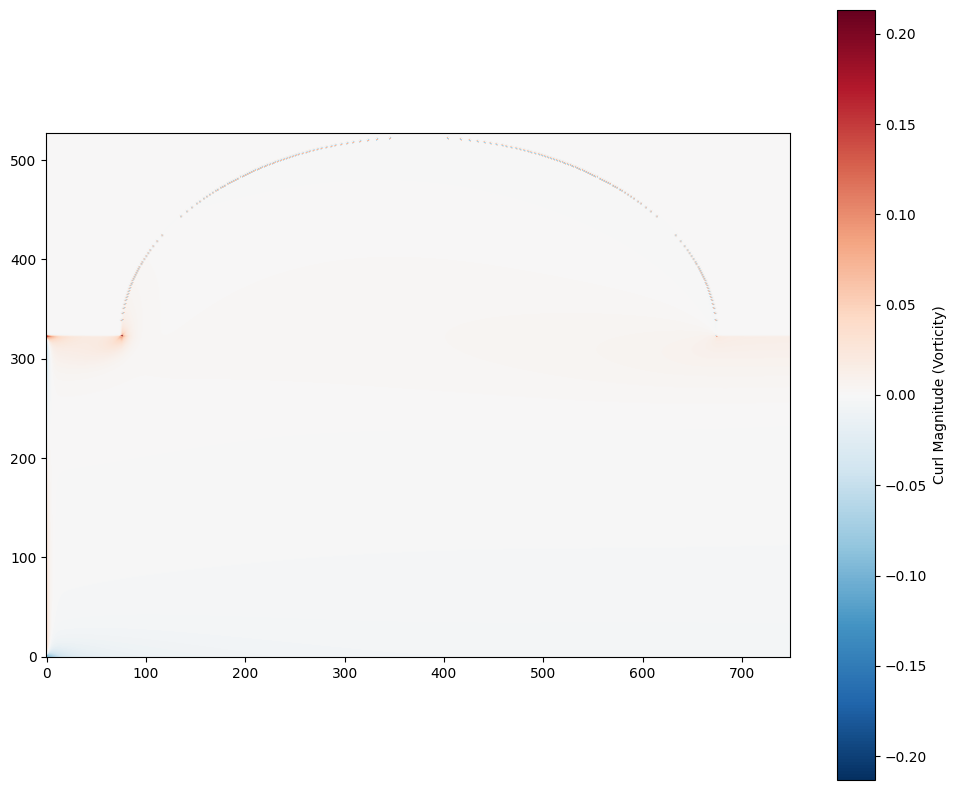

In [ ]:
def create_curl_visualization():
    """Add visualization for curl/vorticity of the vector field"""
    
    if vtk_files and fields:
        # Create curl visualization widgets
        curl_viz_title = widgets.HTML("<h3>Curl/Vorticity Visualization</h3>")
        
        # Create control widgets
        curl_frame_slider = widgets.IntSlider(
            value=0,
            min=0,
            max=len(vtk_files) - 1,
            step=1,
            description='Frame:',
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        
        # Colormap selection
        curl_colormap = widgets.Dropdown(
            options=['RdBu_r', 'seismic', 'coolwarm', 'bwr', 'jet'],
            value='RdBu_r',
            description='Colormap:',
            disabled=False,
            tooltip='Colormap for curl visualization (diverging colormaps work best)'
        )
        
        # Visualization type
        viz_type = widgets.RadioButtons(
            options=['Curl Magnitude', 'Curl with Vectors', 'Streamlines'],
            value='Curl Magnitude',
            description='Display:',
            disabled=False,
            layout=widgets.Layout(width='300px')
        )
        
        # Vector overlay density (only used with vectors option)
        vector_density = widgets.IntSlider(
            value=20,
            min=5,
            max=50,
            step=5,
            description='Vector Density:',
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d',
            disabled=True
        )
        
        # Play/Pause button for animation
        curl_play_button = widgets.Play(
            value=0,
            min=0,
            max=len(vtk_files) - 1,
            step=1,
            interval=200,
            description="Play",
            disabled=False
        )
        
        # Link play button to frame slider
        widgets.jslink((curl_play_button, 'value'), (curl_frame_slider, 'value'))
        
        # Output area for the curl plot
        curl_output = widgets.Output()
        
        # Toggle vector density control based on viz type
        def toggle_vector_controls(change):
            vector_density.disabled = change['new'] != 'Curl with Vectors'
        
        viz_type.observe(toggle_vector_controls, 'value')
        
        # Function to calculate curl of a 2D vector field
        def calculate_curl_2d(u_x, u_y):
            """
            Calculate the curl (vorticity) of a 2D vector field.
            For 2D, curl is a scalar representing rotation around z-axis.
            
            Parameters:
            u_x (ndarray): x-component of velocity
            u_y (ndarray): y-component of velocity
            
            Returns:
            ndarray: curl values (dvx/dy - dvy/dx)
            """
            # Get dimensions
            rows, cols = u_x.shape
            
            # Initialize curl array
            curl = np.zeros((rows, cols))
            
            # Calculate derivatives using central differences
            # Interior points
            dvx_dy = np.zeros_like(u_x)
            dvy_dx = np.zeros_like(u_y)
            
            # Use central differences for interior points
            dvx_dy[1:-1, :] = (u_x[2:, :] - u_x[:-2, :]) / 2.0
            dvy_dx[:, 1:-1] = (u_y[:, 2:] - u_y[:, :-2]) / 2.0
            
            # Use forward/backward differences for boundaries
            # Top edge
            dvx_dy[0, :] = u_x[1, :] - u_x[0, :]
            # Bottom edge
            dvx_dy[-1, :] = u_x[-1, :] - u_x[-2, :]
            # Left edge
            dvy_dx[:, 0] = u_y[:, 1] - u_y[:, 0]
            # Right edge
            dvy_dx[:, -1] = u_y[:, -1] - u_y[:, -2]
            
            # Compute curl = dvx/dy - dvy/dx
            curl = dvx_dy - dvy_dx
            
            return curl
        
        # Function to update the curl visualization
        def update_curl_viz(change=None):
            frame_index = curl_frame_slider.value
            cmap = curl_colormap.value
            display_type = viz_type.value
            density = vector_density.value
            
            # Load the VTK file
            vtk_file = vtk_files[frame_index]
            data_fields, dimensions, _ = read_vtk_file(vtk_file)
            
            with curl_output:
                clear_output(wait=True)
                
                if not data_fields or 'u_x' not in data_fields or 'u_y' not in data_fields:
                    print(f"Error: Velocity components not found in {vtk_file}")
                    return
                
                # Extract velocity components
                u_x = data_fields['u_x']
                u_y = data_fields['u_y']
                
                # Calculate curl
                curl = calculate_curl_2d(u_x, u_y)
                
                # Calculate velocity magnitude for reference
                velocity_mag = np.sqrt(u_x**2 + u_y**2)
                
                # Create figure
                if display_type == 'Curl Magnitude':
                    fig, ax = plt.subplots(figsize=(12, 10))
                    
                    # Plot curl
                    # Use symmetric color limits for better visualization of positive/negative curl
                    curl_max = np.max(np.abs(curl))
                    im = ax.imshow(curl, cmap=cmap, origin='lower', vmin=-curl_max, vmax=curl_max)
                    cbar = plt.colorbar(im, ax=ax, label='Curl Magnitude (Vorticity)')
                    
                    ax.set_title(f"Curl/Vorticity - {os.path.basename(vtk_file)}")
                    ax.set_aspect('equal')
                    
                elif display_type == 'Curl with Vectors':
                    fig, ax = plt.subplots(figsize=(12, 10))
                    
                    # Plot curl as background
                    curl_max = np.max(np.abs(curl))
                    im = ax.imshow(curl, cmap=cmap, origin='lower', vmin=-curl_max, vmax=curl_max)
                    cbar = plt.colorbar(im, ax=ax, label='Curl Magnitude (Vorticity)')
                    
                    # Overlay velocity vectors
                    rows, cols = u_x.shape
                    
                    # Subsample the velocity field to avoid overcrowding
                    step_y = max(1, rows // density)
                    step_x = max(1, cols // density)
                    
                    y_indices = np.arange(0, rows, step_y)
                    x_indices = np.arange(0, cols, step_x)
                    
                    X, Y = np.meshgrid(x_indices, y_indices)
                    
                    # Sample velocity components at grid points
                    u = u_x[Y, X]
                    v = u_y[Y, X]
                    
                    # Normalize vectors
                    if np.max(velocity_mag) > 0:
                        u_norm = u / np.max(velocity_mag)
                        v_norm = v / np.max(velocity_mag)
                    else:
                        u_norm = u
                        v_norm = v
                    
                    # Add the vectors
                    q = ax.quiver(X, Y, u_norm, v_norm, color='white', 
                                 scale=25, width=0.002, pivot='mid', alpha=0.7)
                    
                    ax.set_title(f"Curl with Velocity Vectors - {os.path.basename(vtk_file)}")
                    ax.set_aspect('equal')
                    
                elif display_type == 'Streamlines':
                    fig, ax = plt.subplots(figsize=(12, 10))
                    
                    # Plot curl as background
                    curl_max = np.max(np.abs(curl))
                    im = ax.imshow(curl, cmap=cmap, origin='lower', vmin=-curl_max, vmax=curl_max)
                    cbar = plt.colorbar(im, ax=ax, label='Curl Magnitude (Vorticity)')
                    
                    # Create a grid for streamlines
                    rows, cols = u_x.shape
                    y, x = np.mgrid[0:rows, 0:cols]
                    
                    # Create streamlines
                    strm = ax.streamplot(x, y, u_x.T, u_y.T, color='white', linewidth=1, 
                                      density=1.5, arrowsize=1.2, arrowstyle='->', minlength=0.5)
                    
                    ax.set_title(f"Curl with Streamlines - {os.path.basename(vtk_file)}")
                    ax.set_aspect('equal')
                
                plt.tight_layout()
                plt.show()
                
                # Display statistics
                print(f"Curl/Vorticity Statistics (Frame {frame_index + 1}/{len(vtk_files)}):")
                print(f"  - Min: {np.min(curl):.4f}")
                print(f"  - Max: {np.max(curl):.4f}")
                print(f"  - Mean: {np.mean(curl):.4f}")
                print(f"  - Absolute Mean: {np.mean(np.abs(curl)):.4f}")
                print(f"  - Std Dev: {np.std(curl):.4f}")
                
                # Add interpretation guidance
                print("\nInterpretation Guide:")
                print("  - Positive curl (red): Counter-clockwise rotation")
                print("  - Negative curl (blue): Clockwise rotation")
                print("  - Higher absolute values indicate stronger vortices")
        
        # Connect widgets to update function
        curl_frame_slider.observe(update_curl_viz, 'value')
        curl_colormap.observe(update_curl_viz, 'value')
        viz_type.observe(update_curl_viz, 'value')
        vector_density.observe(update_curl_viz, 'value')
        
        # Create layout
        curl_controls_top = widgets.HBox([curl_play_button, curl_frame_slider])
        curl_controls_bottom = widgets.HBox([curl_colormap, viz_type, vector_density])
        
        # Display all elements
        display(curl_viz_title)
        display(curl_controls_top)
        display(curl_controls_bottom)
        display(curl_output)
        
        # Initial curl visualization
        update_curl_viz()
        
    else:
        print("No VTK files or fields loaded. Cannot create curl visualization.")

# Add the curl visualization as a cell
create_curl_visualization()

In [ ]:
def create_divergence_visualization():
    """Add visualization for divergence of the vector field (expansion/contraction)"""
    
    if vtk_files and fields:
        # Create divergence visualization widgets
        div_viz_title = widgets.HTML("<h3>Divergence Visualization</h3>")
        
        # Create control widgets
        div_frame_slider = widgets.IntSlider(
            value=0,
            min=0,
            max=len(vtk_files) - 1,
            step=1,
            description='Frame:',
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        
        # Colormap selection
        div_colormap = widgets.Dropdown(
            options=['RdBu_r', 'seismic', 'coolwarm', 'bwr', 'viridis'],
            value='RdBu_r',
            description='Colormap:',
            disabled=False,
            tooltip='Colormap for divergence visualization'
        )
        
        # Visualization type
        div_viz_type = widgets.RadioButtons(
            options=['Divergence Only', 'Divergence with Vectors', 'Divergence with Streamlines'],
            value='Divergence Only',
            description='Display:',
            disabled=False,
            layout=widgets.Layout(width='300px')
        )
        
        # Threshold for highlighting significant divergence regions
        div_threshold = widgets.FloatSlider(
            value=0.1,
            min=0.0,
            max=1.0,
            step=0.05,
            description='Threshold:',
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.2f',
            tooltip='Threshold for highlighting divergence (as percentage of max absolute value)'
        )
        
        # Vector overlay density (only used with vectors option)
        div_vector_density = widgets.IntSlider(
            value=20,
            min=5,
            max=50,
            step=5,
            description='Vector Density:',
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d',
            disabled=True
        )
        
        # Play/Pause button for animation
        div_play_button = widgets.Play(
            value=0,
            min=0,
            max=len(vtk_files) - 1,
            step=1,
            interval=200,
            description="Play",
            disabled=False
        )
        
        # Link play button to frame slider
        widgets.jslink((div_play_button, 'value'), (div_frame_slider, 'value'))
        
        # Output area for the divergence plot
        div_output = widgets.Output()
        
        # Toggle vector density control based on viz type
        def toggle_div_vector_controls(change):
            div_vector_density.disabled = change['new'] != 'Divergence with Vectors'
        
        div_viz_type.observe(toggle_div_vector_controls, 'value')
        
        # Function to calculate divergence of a 2D vector field
        def calculate_divergence_2d(u_x, u_y):
            """
            Calculate the divergence of a 2D vector field.
            Divergence represents expansion (positive) or contraction (negative) at each point.
            
            Parameters:
            u_x (ndarray): x-component of velocity
            u_y (ndarray): y-component of velocity
            
            Returns:
            ndarray: divergence values (du_x/dx + du_y/dy)
            """
            # Get dimensions
            rows, cols = u_x.shape
            
            # Initialize divergence array
            div = np.zeros((rows, cols))
            
            # Calculate derivatives using finite differences
            # Interior points
            du_x_dx = np.zeros_like(u_x)
            du_y_dy = np.zeros_like(u_y)
            
            # Use central differences for interior points
            du_x_dx[:, 1:-1] = (u_x[:, 2:] - u_x[:, :-2]) / 2.0
            du_y_dy[1:-1, :] = (u_y[2:, :] - u_y[:-2, :]) / 2.0
            
            # Use forward/backward differences for boundaries
            # Left edge
            du_x_dx[:, 0] = u_x[:, 1] - u_x[:, 0]
            # Right edge
            du_x_dx[:, -1] = u_x[:, -1] - u_x[:, -2]
            # Top edge
            du_y_dy[0, :] = u_y[1, :] - u_y[0, :]
            # Bottom edge
            du_y_dy[-1, :] = u_y[-1, :] - u_y[-2, :]
            
            # Compute divergence = du_x/dx + du_y/dy
            div = du_x_dx + du_y_dy
            
            return div
        
        # Function to update the divergence visualization
        def update_div_viz(change=None):
            frame_index = div_frame_slider.value
            cmap = div_colormap.value
            display_type = div_viz_type.value
            density = div_vector_density.value
            threshold_pct = div_threshold.value
            
            # Load the VTK file
            vtk_file = vtk_files[frame_index]
            data_fields, dimensions, _ = read_vtk_file(vtk_file)
            
            with div_output:
                clear_output(wait=True)
                
                if not data_fields or 'u_x' not in data_fields or 'u_y' not in data_fields:
                    print(f"Error: Velocity components not found in {vtk_file}")
                    return
                
                # Extract velocity components
                u_x = data_fields['u_x']
                u_y = data_fields['u_y']
                
                # Calculate divergence
                div = calculate_divergence_2d(u_x, u_y)
                
                # Calculate velocity magnitude for reference
                velocity_mag = np.sqrt(u_x**2 + u_y**2)
                
                # Calculate threshold value
                div_max = np.max(np.abs(div))
                threshold_value = threshold_pct * div_max
                
                # Create masked arrays for regions above threshold
                sources = np.ma.masked_where(div < threshold_value, div)
                sinks = np.ma.masked_where(div > -threshold_value, div)
                
                # Create figure
                if display_type == 'Divergence Only':
                    fig, ax = plt.subplots(figsize=(12, 10))
                    
                    # Plot divergence with symmetric color limits
                    im = ax.imshow(div, cmap=cmap, origin='lower', vmin=-div_max, vmax=div_max)
                    cbar = plt.colorbar(im, ax=ax, label='Divergence (∇·v)')
                    
                    # Highlight regions with significant divergence
                    if threshold_pct > 0:
                        # Add contour for significant sources (expansion)
                        ax.contour(sources.mask, levels=[0], colors='lime', linewidths=1.5, 
                                  linestyles='solid', alpha=0.7)
                        # Add contour for significant sinks (contraction)
                        ax.contour(sinks.mask, levels=[0], colors='magenta', linewidths=1.5, 
                                  linestyles='solid', alpha=0.7)
                    
                    ax.set_title(f"Divergence Field - {os.path.basename(vtk_file)}")
                    ax.set_aspect('equal')
                    
                elif display_type == 'Divergence with Vectors':
                    fig, ax = plt.subplots(figsize=(12, 10))
                    
                    # Plot divergence as background
                    im = ax.imshow(div, cmap=cmap, origin='lower', vmin=-div_max, vmax=div_max)
                    cbar = plt.colorbar(im, ax=ax, label='Divergence (∇·v)')
                    
                    # Overlay velocity vectors
                    rows, cols = u_x.shape
                    
                    # Subsample the velocity field to avoid overcrowding
                    step_y = max(1, rows // density)
                    step_x = max(1, cols // density)
                    
                    y_indices = np.arange(0, rows, step_y)
                    x_indices = np.arange(0, cols, step_x)
                    
                    X, Y = np.meshgrid(x_indices, y_indices)
                    
                    # Sample velocity components at grid points
                    u = u_x[Y, X]
                    v = u_y[Y, X]
                    
                    # Normalize vectors
                    if np.max(velocity_mag) > 0:
                        u_norm = u / np.max(velocity_mag)
                        v_norm = v / np.max(velocity_mag)
                    else:
                        u_norm = u
                        v_norm = v
                    
                    # Add the vectors
                    q = ax.quiver(X, Y, u_norm, v_norm, color='white', 
                                 scale=25, width=0.002, pivot='mid', alpha=0.7)
                    
                    # Highlight regions with significant divergence
                    if threshold_pct > 0:
                        ax.contour(sources.mask, levels=[0], colors='lime', linewidths=1.5, 
                                  linestyles='solid', alpha=0.7)
                        ax.contour(sinks.mask, levels=[0], colors='magenta', linewidths=1.5, 
                                  linestyles='solid', alpha=0.7)
                    
                    ax.set_title(f"Divergence with Velocity Vectors - {os.path.basename(vtk_file)}")
                    ax.set_aspect('equal')
                    
                elif display_type == 'Divergence with Streamlines':
                    fig, ax = plt.subplots(figsize=(12, 10))
                    
                    # Plot divergence as background
                    im = ax.imshow(div, cmap=cmap, origin='lower', vmin=-div_max, vmax=div_max)
                    cbar = plt.colorbar(im, ax=ax, label='Divergence (∇·v)')
                    
                    # Create a grid for streamlines
                    rows, cols = u_x.shape
                    y, x = np.mgrid[0:rows, 0:cols]
                    
                    # Create streamlines
                    strm = ax.streamplot(x, y, u_x.T, u_y.T, color='white', linewidth=1, 
                                      density=1.5, arrowsize=1.2, arrowstyle='->', minlength=0.5)
                    
                    # Highlight regions with significant divergence
                    if threshold_pct > 0:
                        ax.contour(sources.mask, levels=[0], colors='lime', linewidths=1.5, 
                                  linestyles='solid', alpha=0.7)
                        ax.contour(sinks.mask, levels=[0], colors='magenta', linewidths=1.5, 
                                  linestyles='solid', alpha=0.7)
                    
                    ax.set_title(f"Divergence with Streamlines - {os.path.basename(vtk_file)}")
                    ax.set_aspect('equal')
                
                plt.tight_layout()
                plt.show()
                
                # Add legend explanation for the contours
                if threshold_pct > 0:
                    from matplotlib.lines import Line2D
                    legend_elements = [
                        Line2D([0], [0], color='lime', lw=2, label=f'Sources (∇·v > {threshold_value:.4f})'),
                        Line2D([0], [0], color='magenta', lw=2, label=f'Sinks (∇·v < {-threshold_value:.4f})')
                    ]
                    plt.figure(figsize=(10, 0.5))
                    plt.axis('off')
                    plt.legend(handles=legend_elements, loc='center', ncol=2)
                    plt.tight_layout()
                    plt.show()
                
                # Display statistics
                print(f"Divergence Statistics (Frame {frame_index + 1}/{len(vtk_files)}):")
                print(f"  - Min: {np.min(div):.4f}")
                print(f"  - Max: {np.max(div):.4f}")
                print(f"  - Mean: {np.mean(div):.4f}")
                print(f"  - Absolute Mean: {np.mean(np.abs(div)):.4f}")
                print(f"  - Std Dev: {np.std(div):.4f}")
                
                # Count significant source and sink areas
                if threshold_pct > 0:
                    source_count = np.sum(div > threshold_value)
                    sink_count = np.sum(div < -threshold_value)
                    total_points = div.size
                    print(f"\nSignificant areas (threshold = {threshold_value:.4f}):")
                    print(f"  - Source regions: {source_count} points ({source_count/total_points*100:.2f}% of domain)")
                    print(f"  - Sink regions: {sink_count} points ({sink_count/total_points*100:.2f}% of domain)")
                
                # Add interpretation guidance
                print("\nInterpretation Guide:")
                print("  - Positive divergence (red): Flow expansion (sources)")
                print("  - Negative divergence (blue): Flow contraction (sinks)")
                print("  - Zero divergence: Incompressible flow with no expansion/contraction")
                print("  - In incompressible flow (like blood), significant divergence may indicate:")
                print("    * 3D effects in 2D projection")
                print("    * Numerical artifacts")
                print("    * Areas with flow entering/leaving the plane")
        
        # Connect widgets to update function
        div_frame_slider.observe(update_div_viz, 'value')
        div_colormap.observe(update_div_viz, 'value')
        div_viz_type.observe(update_div_viz, 'value')
        div_vector_density.observe(update_div_viz, 'value')
        div_threshold.observe(update_div_viz, 'value')
        
        # Create layout
        div_controls_top = widgets.HBox([div_play_button, div_frame_slider])
        div_controls_middle = widgets.HBox([div_colormap, div_threshold])
        div_controls_bottom = widgets.HBox([div_viz_type, div_vector_density])
        
        # Display all elements
        display(div_viz_title)
        display(div_controls_top)
        display(div_controls_middle)
        display(div_controls_bottom)
        display(div_output)
        
        # Initial divergence visualization
        update_div_viz()
        
    else:
        print("No VTK files or fields loaded. Cannot create divergence visualization.")

# Add the divergence visualization as a cell
create_divergence_visualization()

HTML(value='<h3>Divergence Visualization</h3>')

Output()

Error reading file header: 'ascii' codec can't decode byte 0xe8 in position 178: ordinal not in range(128)
Found 5 arrays in cell data
Processing 5 cell data arrays
Found fields: rho, u_x, u_y, u_magnitude, wss


## Export Functionality

Let's add functionality to export frames as images or data.

In [9]:
if vtk_files and fields:
    # Create export widgets
    export_field = widgets.Dropdown(
        options=field_names,
        value=default_field,
        description='Field:',
        disabled=False,
    )
    
    export_format = widgets.Dropdown(
        options=['PNG Images', 'NumPy Arrays', 'CSV Files'],
        value='PNG Images',
        description='Format:',
        disabled=False,
    )
    
    export_frames = widgets.RadioButtons(
        options=['All Frames', 'Current Frame Only'],
        value='All Frames',
        description='Frames:',
        disabled=False
    )
    
    export_button = widgets.Button(
        description='Export Data',
        disabled=False,
        button_style='', 
        tooltip='Export data in selected format'
    )
    
    export_output = widgets.Output()
    
    # Function to handle export
    def export_data(b):
        field = export_field.value
        format_type = export_format.value
        all_frames = export_frames.value == 'All Frames'
        
        with export_output:
            clear_output(wait=True)
            
            # Create export directory
            export_dir = os.path.join(os.getcwd(), f"vtk_export_{field}")
            os.makedirs(export_dir, exist_ok=True)
            print(f"Exporting to directory: {export_dir}")
            
            # Determine frames to export
            if all_frames:
                frames_to_export = range(len(vtk_files))
                print(f"Exporting all {len(frames_to_export)} frames...")
            else:
                frames_to_export = [frame_slider.value]
                print(f"Exporting frame {frames_to_export[0]+1}...")
            
            # Export based on format
            for i in frames_to_export:
                vtk_file = vtk_files[i]
                filename_base = os.path.splitext(os.path.basename(vtk_file))[0]
                
                # Load data
                fields_data, _, _ = read_vtk_file(vtk_file)
                
                if fields_data and field in fields_data:
                    data = fields_data[field]
                    
                    # Export based on format type
                    if format_type == 'PNG Images':
                        output_file = os.path.join(export_dir, f"{filename_base}_{field}.png")
                        plt.figure(figsize=(10, 8))
                        plt.imshow(data, cmap='viridis', origin='lower')
                        plt.colorbar(label=field)
                        plt.title(f"{filename_base} - {field}")
                        plt.tight_layout()
                        plt.savefig(output_file, dpi=300)
                        plt.close()
                        
                    elif format_type == 'NumPy Arrays':
                        output_file = os.path.join(export_dir, f"{filename_base}_{field}.npy")
                        np.save(output_file, data)
                        
                    elif format_type == 'CSV Files':
                        output_file = os.path.join(export_dir, f"{filename_base}_{field}.csv")
                        np.savetxt(output_file, data, delimiter=',', fmt='%.6f')
                    
                    # Print progress every 10 frames or for single frame
                    if not all_frames or i % 10 == 0:
                        print(f"Exported {i+1}/{len(frames_to_export)}: {os.path.basename(output_file)}")
            
            print(f"\nExport complete! Files saved to {export_dir}")
    
    export_button.on_click(export_data)
    
    # Display export widgets
    display(widgets.HTML("<h3>Export Data</h3>"))
    display(widgets.HBox([export_field, export_format, export_frames, export_button]))
    display(export_output)

HTML(value='<h3>Export Data</h3>')

Output()

## Conclusion

This notebook provides interactive visualization and analysis tools for VTK files from aneurysm simulations. You can:

1. Browse through VTK files and visualize different fields
2. Analyze trends across all frames
3. Compare frames side by side and view differences
4. Export data in various formats

Feel free to customize this notebook for your specific needs!